# Assignment 6: Harmonic model

This exercise on the Harmonic model will help you better understand the issue of fundamental frequency ($f_0$) estimation by analyzing several sound examples with harmonic content. There are four parts to this exercise: 1) Estimate fundamental frequency, $f_0$, in an polyphonic audio file, 2) Segmentation of stable note regions in an audio signal using $f_0$, 3) Compute amount of inharmonicity present in a sound, and 4) Improving the implementation of the two way mismatch $f_0$ estimation algorithm.

### Relevant Concepts

__Harmonic model parameters:__ The Harmonic model is used for the analysis of harmonic sounds. The file `harmonicModel.py` provides the code for Harmonic model analysis and synthesis. The key component of the harmonic model is the estimation of the fundamental frequency ($f_0$) and its harmonics. Apart from parameters that have been covered in previous exercises, such as the window, FFT size or the peak picking threshold, we have a few additional parameters used by the harmonic model. 

1. `nH`: maximum number of harmonics to be used in the analysis.
2. `maxf0`: maximum $f_0$ frequency in Hz to be considered. 
3. `minf0`: minimum $f_0$ frequency in Hz to be considered. Setting the `maxf0` and `minf0` accurately help to narrow down the $f_0$ candidates used by TWM algorithm and lead to better $f_0$ estimation. 
4. `f0et`: error threshold in the $f_0$ detection. This is the maximum error allowed in the TWM algorithm. If the TWM mismatch error is larger than `f0et`, no $f_0$ is detected and the TWM algorithm returns $f_0 = 0$ for the frame. 
5. `harmDevSlope`: slope of harmonic deviation allowed in the estimated harmonic frequency, compared to a perfect harmonic frequency. This is used to compute the threshold to generate the harmonics. 

__Melody representation:__ For computational analysis, melody is represented typically by the pitch (fundamental frequency). The fundamental frequency ($f_0$) is usually estimated in $Hz$ but for a musically meaningful representation, we convert $f_0$ from Hz to Cent. Cent is a logarithmic scale computed as 

\begin{equation}
\label{eq:HztoCent}
f_{0,\mathrm{Cents}}=1200\log_{2}\left(\frac{f_{0,\mathrm{Hz}}}{55.0}\right)
\end{equation}

Assuming a tuning frequency of A4 = 440 Hz, the reference frequency used in the Cent scale is the frequency of the note A1 = 55Hz, i.e. 55Hz = 0 Cent. 

__Segmentation and transcription:__
Audio segmentation and transcription are two important music information retrieval tasks. Audio segmentation aims to segment the audio into musically meaningful entities. Music Transcription aims to automatically obtain a score-like representation from a music audio piece. Segmentation is often a preprocessing step in transcription. Both these tasks have several different approaches that have been explored. 

In this exercise, we will consider a simple approach to note level segmentation of melodies. Given the audio file, we first estimate the pitch (fundamental frequency $f_0$) for the whole file. We then segment the pitch contour into stable regions. The stable regions most likely correspond to notes of the melody. We then have the start and end time stamps of each note played in the melody. A limitation of this approach to segmentation is that it might not work for notes with a vibrato. 

You will only implement the segmentation as described above. However, additionally for each segment, given a tuning frequency (say A = 440 Hz), you can obtain the notes played in the melody by quantizing the pitch in each segment to a note - a note level transcription of the melody. 

__Inharmonicity:__ In music, inharmonicity is the degree to which the frequencies of the partials depart from integer multiples of the fundamental frequency (harmonic series). An ideal, homogeneous, infinitesimally thin or infinitely flexible string or column of air has exactly harmonic modes of vibration. However, in any real musical instrument, the resonant body that produces the music tone - typically a string, wire, or column of air—deviates from this ideal and has some small or large amount of inharmonicity. You can read more about inharmonicity at http://en.wikipedia.org/wiki/Inharmonicity. 

A typical example of an instrument that exhibits inharmonicity is the piano. For the piano, several models have been proposed to obtain the partials of the piano, which can be used to estimate the inharmonicity. One of the models proposed by Fletcher (Harvey Fletcher, "Normal Vibration Frequencies of a Stiff Piano String", J. Acoust. Soc. Am. 36, 203 (1964); http://dx.doi.org/10.1121/1.1918933) is shown in the following equation, where $f_r$ is the frequency of the $r^{\mathrm{th}}$ partial, $f_0$ is the fundamental frequency and $B$ is the inharmonicity coefficient.

\begin{equation}
\label{eq:fletcher}
 f_r = rf_{0}\sqrt{(1+Br^{2})}
\end{equation}

In this exercise, you will measure the inharmonicity in a piano note using the harmonic model. With the estimates of the fundamental frequency $f_0$ and of the harmonics $\mathbf{f}_{est}$ for a frame $l$, we can obtain a measure of inharmonicity as, 

\begin{equation}
\label{eq:inharm}
I[l]=\frac{1}{R}\overset{R}{\underset{r=1}{\sum}}\left(\frac{\left|f_{\mathrm{est}}^{r}[l]-r\, f_{0}[l]\right|}{r}\right)
\end{equation}

where $R$ is the number of harmonics (the number of harmonics being used to compute inharmonicity), $f_0[l]$ is the fundamental frequency estimated at the frame $l$ and $f_{\mathrm{est}}^{r}[l]$ is the estimated frequency of the $r^{\mathrm{th}}$ harmonic at the frame. Note that the first harmonic is the fundamental. 

We can then compute the mean inharmonicity in a specific time region between the frame indexes $l_1$ and $l_2$ as,

\begin{equation}
I_{\mathrm{mean}} = \frac{1}{l_2-l_1+1}\overset{l_2}{\underset{l=l_1}{\sum}}I[l]
\end{equation}

__TWM algorithm candidate selection:__ The two way mismatch algorithm implemented in sms-tools needs a set of $f_0$ candidates to start with. An easy choice of candidates are the peaks of the magnitude spectrum within a specific range of frequencies. However, this way of choosing $f_0$ candidates fails when there is no peak corresponding to the true $f_0$ value. The generation of $f_0$ candidates can be done better by also including the sub-harmonics of the peak frequencies as $f_0$ candidates. 

__Searching numpy arrays:__ Numpy provides an efficient way to search for a specific element(s) of an array that satisfy a given condition. You can use `np.where()` in such cases. e.g. Given a numpy array `a = array([ 0.9193727 ,  0.6359579 ,  0.8335968 ,  0.20568055,  0.13874869])` and you want to extract the indexes of elements less than 0.5, you can use `np.where(a<0.5)[0]`. The function returns `array([3, 4])` corresponding the indexes of the elements in `a` less than 0.5. 

## Part 1 - Estimate one fundamental frequency in a polyphonic audio signal

Perform a good fundamental frequency estimation of one sound source within a simple polyphonic sound using the Two-way mismatch algorithm. 

The sound is a cello recording `cello-double-2.wav`, in which two strings are played simultaneously. One string 
plays a constant drone while the other string plays a simple melody. You have to choose the analysis parameter values such that the `f0` frequency of the simple melody is tracked.
 
The core function used is `f0Detection()`, part of the `harmonicModel.py` module, which in turn uses the Two-way mismatch algorithm. Of all possible analysis parameters we will focus on the following ones:

1. `window` (string): analysis window
2. `M` (integer): window size used for computing the spectrum
3. `N` (integer): FFT size used for computing the spectrum
4. `f0et` (float): error threshold used for the f0 computation
5. `t` (float): magnitude threshold in dB used in spectral peak picking
6. `minf0` (float): minimum fundamental frequency in Hz
7. `maxf0` (float): maximum fundamental frequency in Hz

Be cautious while choosing the window size. Window size should be large enough to resolve the spectral peaks and small enough to preserve the note transitions. Very large window sizes may smear the `f0` contour at note transitions.

NOTE: Do not do just trial and error. Understand the problem and choose the parameters that should work best. Then test it and refine the parameters by trying different parameter values and visualizing/hearing the output `f0`. The output will not be perfect, so try to understand the problems encountered.

In [1]:
import os
import sys
import numpy as np
import math
from scipy.signal import get_window
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('../software/models/')
import utilFunctions as UF
import harmonicModel as HM
import sineModel as SM
import stft
import dftModel as DFT

eps = np.finfo(float).eps

7350
8192


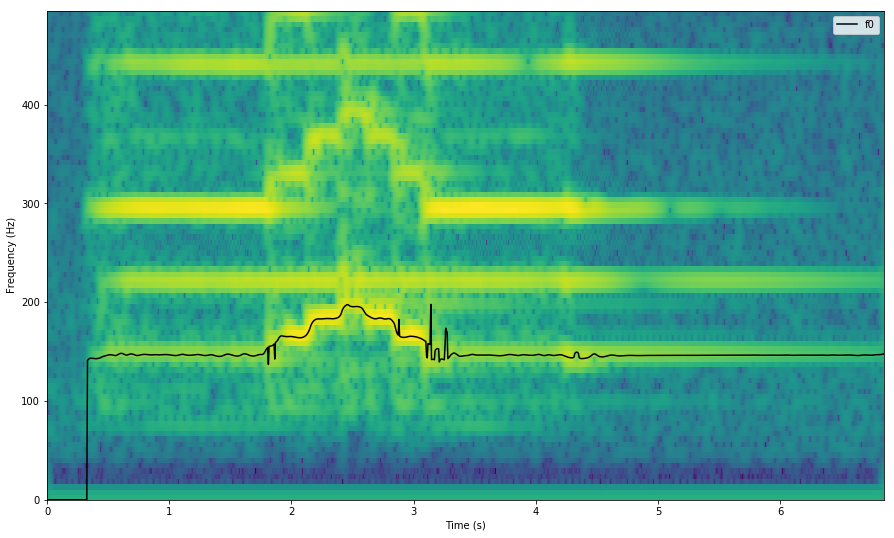

In [2]:
# E6 - 1.1: Set the analysis parameters of f0Detection() to perform the best f0 dectection of the melody 
# present in cello-double-2.wav

input_file = '../sounds/cello-double-2.wav'
    
### Change these analysis parameter values marked as XX

'''
window = XX
M = XX
N = XX
f0et = XX
t = XX
minf0 = XX
maxf0 = XX
'''

window = "blackman"
M = int( 10 * (44100/60))
print(M)
N = int(pow(2, np.ceil(np.log2(M))))
print(N)
f0et = 8
t = -80
minf0 = 130
maxf0 = 200


# No need to modify the code below, just understand it
H = 256 
fs, x = UF.wavread(input_file)
w  = get_window(window, M)   
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et) 
y = UF.sinewaveSynth(f0, 0.8, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

# Code for plotting the f0 contour on top of the spectrogram
maxplotfreq = 500.0    
fig = plt.figure(figsize=(15, 9))

mX, pX = stft.stftAnal(x, w, N, H) 
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
plt.pcolormesh(timeStamps, binFreqs, mX)
plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
    
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.legend(('f0',))
plt.show()

In this part of the exercise, we try to find the values related with the window, and the values of the interval where we want to find the fundamental frequency. To do so, we used the tool given in the sms-tools, in the sofwtare/models_interface/ section, called 'models_GUI.py', where we compute the harmonics of the input sound 'cello-double-2.wav'. As in this sound we have two diferent strings of a cello beign played at the same time, where one of them is remaining constant over the time, but the other is playing a litle melody, what we want is to extract the fundamental frequency in each frame of the string that is playing the melody.

To be able to achieve this, we first computed the algorithm using the blackman window (because this is one of the most used in music), and by using the equation described in theory lectures, that allow us to get the value of the window size, and then the value of the FT, we obtained that this window size has to be, at least 5292, because of the number of bins of the blackman (6), the fs (44100), and the mean of diference between the strings in a cello (arround 50Hz), hence N needs to be 8192 

Once we get the first result, we observed that the spectrum shows us the frequencies of both strings over time, and its respective harmonics, with a poor frequency resolution. We also observed that the shape of the frequency of the melody over the time is diferent respect to the frequency of the string that remains constant, due to that, we changed our parameters of minf0 and maxf0, to 130 and 200 respective, because is between this interval that the frequencies representing the melody are located (fundamental harmonic). Another thing we can observe with the default configuration is that, the fundamental frequency of the "melody string" and the fundamental frequency of the "constant string" interacts in a certain point (when the melody achieves it maximum frequency), what makes us be aware of the parameters 

## Part 2 - Segmentation of stable frequency regions of an audio signal

The function `segment_stable_frequency_regions()` identifies the stable fundamental frequency regions of a given sound. The function returns the start and end frame indexes of each a stable region.

The arguments to the function are the fundamental frequency of a monophonic audio signal (`f0`), threshold to 
be used for deciding stable notes (`stdThsld`) in cents, minimum allowed duration of a stable note (`minNoteDur`), 
number of samples to be considered for computing standard deviation (`winStable`). The function returns a numpy array of `shape (k,2)`, where `k` is the total number of detected segments. The two columns in each row contains the starting and the ending frame indexes of a stable note segment. The segments are returned in the increasing order of their start times. 

In this exercise you should use this function to identify the notes of a monophonic musical phrase.

In [3]:
# function used in exercise
    
def segment_stable_frequency_regions(f0, stdThsld, minNoteDur, winStable):
    """Segment the stable regions of a fundamental frequency track.
    
    Args:
        f0 (np.array): f0 values of a sound
        stdThsld (float): threshold for detecting stable regions in the f0 contour (in cents)
        minNoteDur (float): minimum allowed segment length (note duration)  
        winStable (int): number of samples used for computing standard deviation
        
    Result:
        segments (np.array): starting and ending frame indexes of every segment
        
    """
    
    # convert f0 values from Hz to Cents (as described in pdf document)
    f0Cents = 1200*np.log2((f0+eps)/55.0)  

    # create an array containing standard deviation of last winStable samples
    stdArr = 10000000000*np.ones(f0.shape)
    for ii in range(winStable-1, len(f0)):
        stdArr[ii] = np.std(f0Cents[ii-winStable+1:ii+1])

    # apply threshold on standard deviation values to find indexes of the stable points in melody
    indFlat = np.where(stdArr<=stdThsld)[0]
    flatArr = np.zeros(f0.shape)
    flatArr[indFlat] = 1

    # create segments of continuous stable points such that consecutive stable points belong to same segment
    onset = np.where((flatArr[1:]-flatArr[:-1])==1)[0]+1
    offset = np.where((flatArr[1:]-flatArr[:-1])==-1)[0] 
    
    # remove any offset before onset (to sync them)
    indRem = np.where(offset<onset[0])[0]              
    offset = np.delete(offset, indRem)
    
    minN = min(onset.size, offset.size)
    segments = np.transpose(np.vstack((onset[:minN], offset[:minN])))

    # apply segment filtering, i.e. remove segments with are < minNoteDur in length
    minNoteSamples = int(np.ceil(minNoteDur*fs/H))
    diff = segments[:,1] - segments[:,0]
    indDel = np.where(diff<minNoteSamples)
    segments = np.delete(segments,indDel, axis=0)

    return segments

Run `segment_stable_frequency_regions()`, using the test cases to validate your code.

__Test case 1:__ Using `input_file='../sounds/cello-phrase.wav', stdThsld=10, minNoteDur=0.1, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650`, 
the function `segment_stable_frequency_regions()` should return 9 segments. 

__Test case 2:__ Using `input_file='../sounds/cello-phrase.wav', stdThsld=20, minNoteDur=0.5, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650`, 
the function `segment_stable_frequency_regions()` should return 6 segments. 

__Test case 3:__ Using `input_file='../sounds/sax-phrase-short.wav', stdThsld=5, minNoteDur=0.6, 
winStable = 3, window='hamming', M=1025, N=2048, H=256, f0et=5.0, t=-100, minf0=310, maxf0=650`, 
the function `segment_stable_frequency_regions()` should return just one segment. 

We include all the needed code to compute f0. Call the function `segment_stable_frequency_regions()`, and plot the `f0` contour and the detected segments on the top of the spectrogram of the audio signal. 

Analyse the outcome of your function and compare different cases. Try different sounds. 

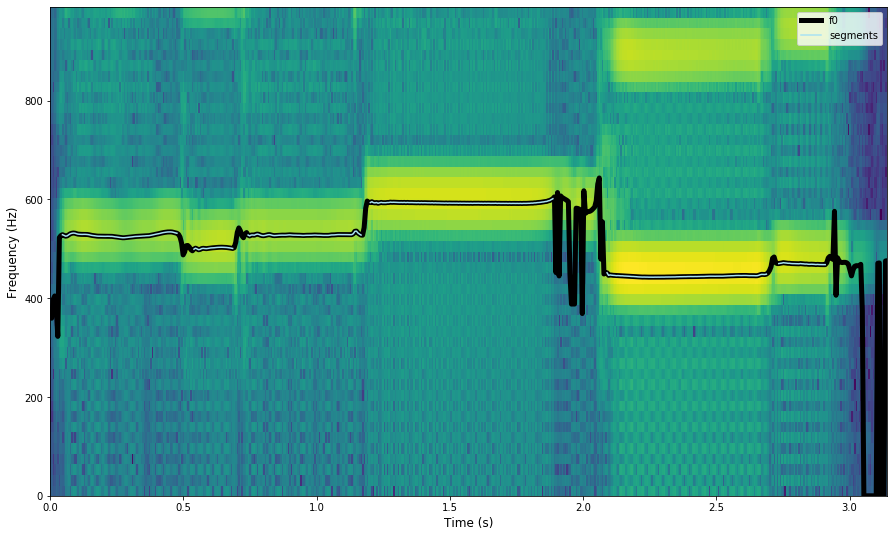

In [11]:
# E6 - 2.1: Compute the fundamental frequency of sax-phrase-short.wav, call egment_stable_frequency_regions(), and
# plot spectrogram, f0, and segments

### parameters to change

"""
input_file = 'XX'
stdThsld = XX
minNoteDur = XX 
winStable = XX
window = 'XX'
M = XX
N = XX
H = XX
f0et = XX
t = XX
minf0 = XX
maxf0 = XX

"""
input_file = '../sounds/sax-phrase-short.wav'
stdThsld = 10
minNoteDur = 0.1 
winStable = 3
window = 'hamming'
M = 1024
N = 2048
H = 256
f0et = 5.0
t = -100
minf0 = 310
maxf0 = 650


# no need to change any code after here

# compute f0 and segments
fs, x = UF.wavread(input_file) 
w  = get_window(window, M)   
f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)
segments = segment_stable_frequency_regions(f0,stdThsld, minNoteDur,winStable)

# plot spectrogram, f0, and segments
maxplotfreq = 1000.0    

plt.figure(figsize=(15, 9))

mX, pX = stft.stftAnal(x, w, N, H)
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
plt.pcolormesh(timeStamps, binFreqs, mX)
plt.plot(timeStamps, f0, color = 'k', linewidth=5)

for i in range(segments.shape[0]):
    plt.plot(timeStamps[segments[i,0]:segments[i,1]], f0[segments[i,0]:segments[i,1]], color = '#A9E2F3', linewidth=1.5)        
plt.ylabel('Frequency (Hz)', fontsize = 12)
plt.xlabel('Time (s)', fontsize = 12)
plt.legend(('f0','segments'))  

## Part 3 - Compute amount of inharmonicity present in a sound

Complete the function `estimate_inharmonicity()` to measure the amount of inharmonicity present in a pitched/pseudo-harmonic sound. The function should measure the mean inharmonicity from the harmonics obtained by a harmonic analysis.

The input arguments are the harmonic frequencies and it should return the mean inharmonicity value. 

Use the formula given in the Relevant Concepts section above to compute the inharmonicity measure for the given interval. Note that for some frames some of the harmonics might not be detected due to their low energy. For handling such cases use only the detected harmonics (and set the value of `R` in the equation to the number of detected harmonics) to compute the inharmonicity measure. All the detected harmonics have a non-zero frequency.

In this question we will work with a piano sound (`'../sounds/piano.wav'`), a typical example of an 
instrument that exhibits inharmonicity (http://en.wikipedia.org/wiki/Piano_acoustics#Inharmonicity_and_piano_size). 


In [13]:
# E6 - 3.1: Complete function

def estimate_inharmonicity(xhfreq):
    """Estimate inharmonicify factor from the psedo-harmonic frequencies of a sound.
    
    Args:
        xhfreq (np.array): harmonic frequencies of a sound
        
    Output:
        (float): mean inharmonicity over all the frames
        
    """
    ### Your code here
    devArray = []
    nFrames, nH = xhfreq.shape
    harms = (np.arange(nH)).astype(np.float)+1
    for i in range(0,nFrames):
        dev = abs(xhfreq[i,:]-(xhfreq[i,0]*harms))/harms
        indZero = np.where(xhfreq[i,:]==0)[0]
        dev[indZero] = 0
        if not len(indZero) == nH:
            devArray.append(np.sum(dev)/float(nH-len(indZero)))
    return np.sum(devArray)/float(len(devArray))

Test and run `estimate_inharmonicity()` using the code bellow, which performs the harmonic analysis using the function `harmonicModelAnal()`, calls `estimate_inharmonicity()`, and then plots the harmonics that have been used in the computation. Use the following test cases to validate your code.

__Test case 1:__ If you run your code with `inputFile = '../sounds/piano.wav', t1=0.2, t2=0.4, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=130, maxf0=180, nH = 25`, the returned output should be `1.4607`. 

__Test case 2:__ If you run your code with `inputFile = '../sounds/piano.wav', t1=2.3, t2=2.55, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=230, maxf0=290, nH = 15`, the returned output should be `1.4852`. 

__Test case 3:__ If you run your code with `inputFile = '../sounds/piano.wav', t1=2.55, t2=2.8, window='hamming', M=2047, N=2048, H=128, f0et=5.0, t=-90, minf0=230, maxf0=290, nH = 5`, the returned output should be `0.1743`. 

You should compare the inharmonicities present in the sounds of different instruments. 

0.17431975822217044


Text(0.5, 1.0, 'frequencies of harmonics')

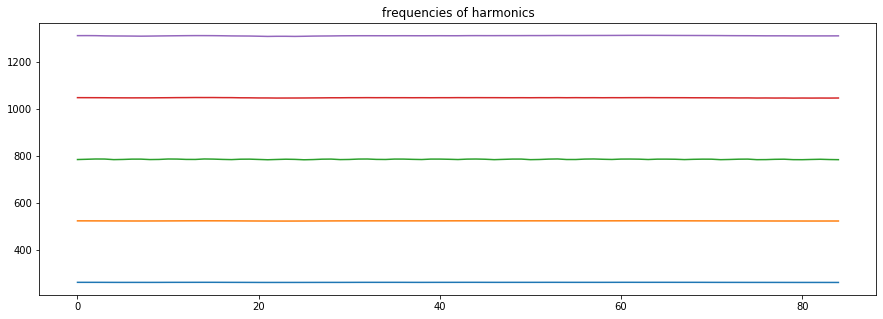

In [14]:
# E6 - 3.2: Read file piano.wav, call harmonicModelAnal() and estimate_inharmonicity()

### Your code here
input_file = '../sounds/piano.wav'
t1 = 2.55
t2 = 2.8
window = 'hamming'
M = 2047
N = 2048
H = 128
f0et = 5.0
t = -90
minf0 = 230
maxf0 = 290
nH = 5

fs, x = UF.wavread(input_file)
w  = get_window(window, M)   
xhfreq, xhmag, xhphase = HM.harmonicModelAnal(x,fs,w,N,H,t,nH,minf0,maxf0,f0et,harmDevSlope=.01,minSineDur=0)

startFrame = int(np.ceil(t1/(H/float(fs))))
endFrame = int(np.floor(t2/(H/float(fs))))

meanInharm = estimate_inharmonicity(xhfreq[startFrame:endFrame,])
print(meanInharm)
plt.figure(figsize=(15, 5))

numFrames = endFrame-startFrame
frmTime = H*np.arange(numFrames)/float(fs)
plt.plot(xhfreq[startFrame:endFrame,])
plt.title('frequencies of harmonics')

## [Optional] Part 4 - Improving the implementation of the two way mismatch f0 estimation algorithm

Try to improve the implementation of the two way mismatch algorithm used for fundamental frequency estimation. There is no definite answer for this question. The main purpose of this part is to understand the limitations of the current implementation of the TWM algorithm.

You should directly modify the core functions that implement the TWM algorithm and that are copied here. Hence, you just need to modify the functions in this file.

Estimating fundamental frequency from an audio signal is still a challenging and unsolved problem. By now you might have realized that many times the performance of the TWM `f0` estimation algorithm falls short of the expectations. There can be a systematic explanation for the scenarios where TWM fails for specific categories or characteristics of the sounds. Some of the known scenarios where the current implementation of the TWM algorithm fails to estimate a correct fundamental frequency are:

1) Missing fundamental frequency: For many sounds the fundamental frequency component is very low and therefore during the spectral peak picking step we do not obtain any peak corresponding to the `f0`. Since the TWM algorithm implemented in sms-tools considers only the detected spectral peaks as the `f0` candidates, we do not get any candidate corresponding to the `f0`. This causes `f0` estimation to fail. For example, such a scenario is encountered in low pitched vocal sounds.
2) Pseudo-harmonicity in the sound: Many instruments, such as piano, exhibit some deviation from perfect harmonicity wherein their harmonic partials are not perfectly located at integral multiples of the fundamental frequency. Since the TWM algorithm computes error function assuming that the harmonic locations are at integral multiples, its performance is poorer when such deviations exist.

In this question we propose to work on these two scenarios. Go to freesound and download sound examples of low pitched vocal sounds and of piano. Run current implementation of TMW to identify the limitations and propose improvements to the code in order to obtain better `f0` estimation for those two particular scenarios. 

The core TWM algorithm is implemented in the function `TWM_p()`, which takes in an array of `f0` candidates and detect the candidate that has the lowest error. `TWM_p()` is called by `f0Twm()`, which generates `f0` candidates `(f0c = np.argwhere((pfreq>minf0) & (pfreq<maxf0))[:,0])`. This function also implements a memory based prunning of the `f0` candidates. If the `f0` contour is found to be stable (no drastic transitions across frames) then only the `f0` candidates close to the stable `f0` value are retained. `f0Twm()` is called for every audio frame by `f0Detection()`.

You should use the code suplied, which calls `f0Detection()` for estimating `f0` and plots the `f0` contour on top of the spectrogram of the sound. 

TIP: An identified limitation of the current implementation for the case of low vocal sounds is that it can only find `f0` if there is a peak present in the magnitude spectrum. A possible improvement is to generate additional `f0` candidates from the identified peaks. Another identified limitation for the case of piano sounds is the assumption of perfect harmonicity. For these sounds you can think of modifying the generation of the ideal harmonic series that is computed in the code, incorporating the typical deviation from harmonicity encountered in piano sounds.

NOTE: Before you start making changes in the TWM implementation make sure you have reached the best possible performance that can be achieved by tuning the analysis parameters. If the analysis parameters are inappropriately set, it is not completely meaningful to just improve the TWM implementation.

To maintain the integrity of the sms-tools package for future assignments, please make changes only to the functions in this file and not the other files in sms-tools.

In the cell below explain what you tried to do and what results did you obtained.

In [16]:
### modify anything
def f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et):
    """
    Fundamental frequency detection of a sound using twm algorithm
    x: input sound; fs: sampling rate; w: analysis window; 
    N: FFT size; t: threshold in negative dB, 
    minf0: minimum f0 frequency in Hz, maxf0: maximim f0 frequency in Hz, 
    f0et: error threshold in the f0 detection (ex: 5),
    returns f0: fundamental frequency
    """
    if (minf0 < 0):                                            # raise exception if minf0 is smaller than 0
        raise ValueError("Minumum fundamental frequency (minf0) smaller than 0")
    
    if (maxf0 >= 10000):                                       # raise exception if maxf0 is bigger than fs/2
        raise ValueError("Maximum fundamental frequency (maxf0) bigger than 10000Hz")
    
    if (H <= 0):                                               # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")
        
    hN = N/2                                                   # size of positive spectrum
    hM1 = int(math.floor((w.size+1)/2))                        # half analysis window size by rounding
    hM2 = int(math.floor(w.size/2))                            # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                             # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM1))                             # add zeros at the end to analyze last sample
    pin = hM1                                                  # init sound pointer in middle of anal window          
    pend = x.size - hM1                                        # last sample to start a frame
    fftbuffer = np.zeros(N)                                    # initialize buffer for FFT
    w = w / sum(w)                                             # normalize analysis window
    f0 = []                                                    # initialize f0 output
    f0t = 0                                                    # initialize f0 track
    f0stable = 0                                               # initialize f0 stable
    while pin<pend:             
        x1 = x[pin-hM1:pin+hM2]                                  # select frame
        mX, pX = DFT.dftAnal(x1, w, N)                           # compute dft           
        ploc = UF.peakDetection(mX, t)                           # detect peak locations   
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)      # refine peak values
        ipfreq = fs * iploc/N                                    # convert locations to Hez
        f0t = f0Twm(ipfreq, ipmag, f0et, minf0, maxf0, f0stable)  # find f0
        if ((f0stable==0)&(f0t>0)) \
                or ((f0stable>0)&(np.abs(f0stable-f0t)<f0stable/5.0)):
            f0stable = f0t                                         # consider a stable f0 if it is close to the previous one
        else:
            f0stable = 0
        f0 = np.append(f0, f0t)                                  # add f0 to output array
        pin += H                                                 # advance sound pointer
    return f0


In [17]:
### modify anything
def f0Twm(pfreq, pmag, ef0max, minf0, maxf0, f0t=0):
    """
    Function that wraps the f0 detection function TWM, selecting the possible f0 candidates
    and calling the function TWM with them
    pfreq, pmag: peak frequencies and magnitudes, 
    ef0max: maximum error allowed, minf0, maxf0: minimum  and maximum f0
    f0t: f0 of previous frame if stable
    returns f0: fundamental frequency in Hz
    """
    if (minf0 < 0):                                  # raise exception if minf0 is smaller than 0
        raise ValueError("Minumum fundamental frequency (minf0) smaller than 0")
    
    if (maxf0 >= 10000):                             # raise exception if maxf0 is bigger than 10000Hz
        raise ValueError("Maximum fundamental frequency (maxf0) bigger than 10000Hz")
        
    if (pfreq.size < 3) & (f0t == 0):                # return 0 if less than 3 peaks and not previous f0
        return 0
    
    f0c = np.argwhere((pfreq>minf0) & (pfreq<maxf0))[:,0] # use only peaks within given range
    if (f0c.size == 0):                              # return 0 if no peaks within range
        return 0
    f0cf = pfreq[f0c]                                # frequencies of peak candidates
    f0cm = pmag[f0c]                                 # magnitude of peak candidates

    if f0t>0:                                        # if stable f0 in previous frame 
        shortlist = np.argwhere(np.abs(f0cf-f0t)<f0t/2.0)[:,0]   # use only peaks close to it
        maxc = np.argmax(f0cm)
        maxcfd = f0cf[maxc]%f0t
        if maxcfd > f0t/2:
            maxcfd = f0t - maxcfd
        if (maxc not in shortlist) and (maxcfd>(f0t/4)): # or the maximum magnitude peak is not a harmonic
            shortlist = np.append(maxc, shortlist)
        f0cf = f0cf[shortlist]                         # frequencies of candidates                     

    if (f0cf.size == 0):                             # return 0 if no peak candidates
        return 0

    f0, f0error = TWM_p(pfreq, pmag, f0cf)        # call the TWM function with peak candidates
    
    if (f0>0) and (f0error<ef0max):                  # accept and return f0 if below max error allowed
        return f0
    else:
        return 0


In [18]:
### modify anything
def TWM_p(pfreq, pmag, f0c):
    """
    Two-way mismatch algorithm for f0 detection (by Beauchamp&Maher)
    [better to use the C version of this function: UF_C.twm]
    pfreq, pmag: peak frequencies in Hz and magnitudes, 
    f0c: frequencies of f0 candidates
    returns f0, f0Error: fundamental frequency detected and its error
    """

    p = 0.5                                          # weighting by frequency value
    q = 1.4                                          # weighting related to magnitude of peaks
    r = 0.5                                          # scaling related to magnitude of peaks
    rho = 0.33                                       # weighting of MP error
    Amax = max(pmag)                                 # maximum peak magnitude
    maxnpeaks = 10                                   # maximum number of peaks used
    harmonic = np.matrix(f0c)
    ErrorPM = np.zeros(harmonic.size)                # initialize PM errors
    MaxNPM = min(maxnpeaks, pfreq.size)
    for i in range(0, MaxNPM) :                      # predicted to measured mismatch error
        difmatrixPM = harmonic.T * np.ones(pfreq.size)
        difmatrixPM = abs(difmatrixPM - np.ones((harmonic.size, 1))*pfreq)
        FreqDistance = np.amin(difmatrixPM, axis=1)    # minimum along rows
        peakloc = np.argmin(difmatrixPM, axis=1)
        Ponddif = np.array(FreqDistance) * (np.array(harmonic.T)**(-p))
        PeakMag = pmag[peakloc]
        MagFactor = 10**((PeakMag-Amax)/20)
        ErrorPM = ErrorPM + (Ponddif + MagFactor*(q*Ponddif-r)).T
        harmonic = harmonic+f0c

    ErrorMP = np.zeros(harmonic.size)                # initialize MP errors
    MaxNMP = min(maxnpeaks, pfreq.size)
    for i in range(0, f0c.size) :                    # measured to predicted mismatch error
        nharm = np.round(pfreq[:MaxNMP]/f0c[i])
        nharm = (nharm>=1)*nharm + (nharm<1)
        FreqDistance = abs(pfreq[:MaxNMP] - nharm*f0c[i])
        Ponddif = FreqDistance * (pfreq[:MaxNMP]**(-p))
        PeakMag = pmag[:MaxNMP]
        MagFactor = 10**((PeakMag-Amax)/20)
        ErrorMP[i] = sum(MagFactor * (Ponddif + MagFactor*(q*Ponddif-r)))

    Error = (ErrorPM[0]/MaxNPM) + (rho*ErrorMP/MaxNMP)  # total error
    f0index = np.argmin(Error)                       # get the smallest error
    f0 = f0c[f0index]                                # f0 with the smallest error

    return f0, Error[f0index]        

Text(0.5, 0, 'Time (s)')

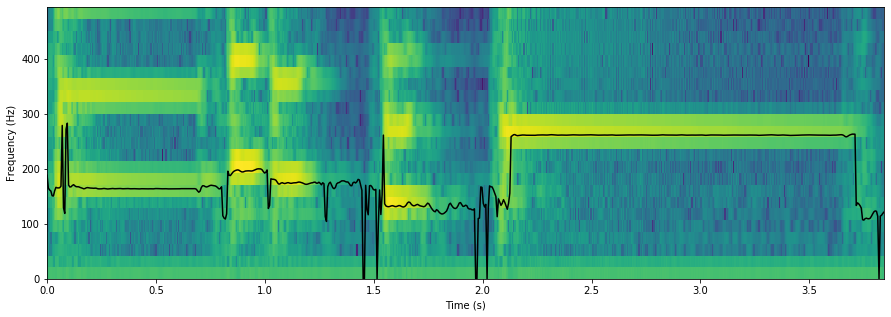

In [19]:
# test the f0Detection()

### modify anything

input_file = '../sounds/piano.wav'
window = 'hamming'
M = 2048
N = 2048
H = 256
f0et = 5.0
t = -80
minf0 = 100
maxf0 = 300

ipd.display(ipd.Audio('../sounds/piano.wav'))
fs, x = UF.wavread(input_file) 
w  = get_window(window, M)  
f0 = f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et)

## Code for plotting the f0 contour on top of the spectrogram
maxplotfreq = 500.0    
plt.figure(figsize=(15, 5))

mX, pX = stft.stftAnal(x, w, N, H) 
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
binFreqs = np.arange(mX.shape[0])*fs/float(N)
    
plt.pcolormesh(timeStamps, binFreqs, mX)
plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)

plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')


In [ ]:
# [Optional] E6 - 4.1: Explain Part 4
'''

'''